In [1]:
!pip install scipy opencv-python

In [2]:
import os
import pandas as pd
from PIL import Image
import torch
from kagglehub import dataset_download
import numpy as np
import cv2
from scipy.ndimage import gaussian_filter
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
import kagglehub
import matplotlib.pyplot as plt
import random

In [4]:
DEVICE   = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

Using device: cuda


In [3]:
# Download latest version
path = kagglehub.dataset_download("agungpambudi/mnist-multiple-dataset-comprehensive-analysis")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/mnist-multiple-dataset-comprehensive-analysis


In [5]:
dataset_path = "/kaggle/input/mnist-multiple-dataset-comprehensive-analysis"
base_path = os.path.join(dataset_path, "PolyMNIST", "MMNIST")

data = []

for split in ["train", "test"]:
    split_path = os.path.join(base_path, split)
    if not os.path.exists(split_path):
        continue
    for modality in os.listdir(split_path):
        modality_path = os.path.join(split_path, modality)
        if not os.path.isdir(modality_path):
            continue
        for file in os.listdir(modality_path):
            if file.endswith(".png"):
                try:
                    label = int(file.split(".")[1])  # Ej: 1234.5.png → 5
                    full_path = os.path.join(modality_path, file)
                    data.append({
                        "file_path": full_path,
                        "label": label,
                        "modality": modality,
                        "split": split
                    })
                except Exception as e:
                    print(f"Error con archivo: {file} → {e}")

df = pd.DataFrame(data)
print("DataFrame generado con", len(df), "registros.")
print(df.head())

DataFrame generado con 350000 registros.
                                           file_path  label modality  split
0  /kaggle/input/mnist-multiple-dataset-comprehen...      9       m4  train
1  /kaggle/input/mnist-multiple-dataset-comprehen...      0       m4  train
2  /kaggle/input/mnist-multiple-dataset-comprehen...      0       m4  train
3  /kaggle/input/mnist-multiple-dataset-comprehen...      9       m4  train
4  /kaggle/input/mnist-multiple-dataset-comprehen...      9       m4  train


In [6]:
class ElasticTransform:
    def __init__(self, alpha=36, sigma=6):
        self.alpha = alpha
        self.sigma = sigma

    def __call__(self, img: Image.Image) -> Image.Image:
        arr = np.array(img)
        shape = arr.shape[:2]
        # campos de desplazamiento
        dx = (np.random.rand(*shape)*2 - 1)
        dy = (np.random.rand(*shape)*2 - 1)
        dx = gaussian_filter(dx, self.sigma) * self.alpha
        dy = gaussian_filter(dy, self.sigma) * self.alpha
        # mallas
        x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
        map_x = (x + dx).astype(np.float32)
        map_y = (y + dy).astype(np.float32)
        # aplica remap canal por canal
        warped = np.stack([
            cv2.remap(arr[...,c], map_x, map_y,
                      interpolation=cv2.INTER_LINEAR,
                      borderMode=cv2.BORDER_REFLECT_101)
            for c in range(3)
        ], axis=2)
        return Image.fromarray(warped)

# Transforms para train / test

transform_train = transforms.Compose([
    transforms.Resize((28,28)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.RandomAffine(
        degrees=0,
        translate=(0.1, 0.1),
        scale=(0.9, 1.1),
        shear=10
    ),
    transforms.ColorJitter(
        brightness=0.2,
        contrast=0.2,
        saturation=0.2,
        hue=0.1
    ),
    transforms.GaussianBlur(kernel_size=(3,3), sigma=(0.1,2.0)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

transform_test = transforms.Compose([
    transforms.Resize((28,28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

In [7]:
class RGBMNISTDataset(Dataset):
    def __init__(self, df, split, transform):
        self.sub = df[df['split']==split].reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.sub)

    def __getitem__(self, i):
        row = self.sub.loc[i]
        img = Image.open(row.file_path).convert("RGB")
        return self.transform(img), row.label

train_ds = RGBMNISTDataset(df, 'train', transform_train)
test_ds  = RGBMNISTDataset(df, 'test',  transform_test)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True,  num_workers=8)
test_loader  = DataLoader(test_ds,  batch_size=64, shuffle=False, num_workers=8)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [8]:
class TwoLayerNet(nn.Module):
    def __init__(self, input_dim=3*28*28, hidden=800, num_classes=10):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden)
        self.fc2 = nn.Linear(hidden, num_classes)

    def forward(self, x):
        # x: [B,3,28,28]
        x = x.view(x.size(0), -1)    # aplanar → [B,3*28*28]
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

Epoch 1/5 | Loss: 1.4604 | Train Acc: 57.65% | Val Loss: 1.4442 | Val Acc: 63.47%
Epoch 2/5 | Loss: 1.2310 | Train Acc: 61.60% | Val Loss: 1.7992 | Val Acc: 64.63%
Epoch 3/5 | Loss: 1.1661 | Train Acc: 63.97% | Val Loss: 1.2697 | Val Acc: 68.60%
Epoch 4/5 | Loss: 1.1292 | Train Acc: 63.64% | Val Loss: 1.4953 | Val Acc: 68.22%
Epoch 5/5 | Loss: 1.1068 | Train Acc: 65.83% | Val Loss: 2.2319 | Val Acc: 66.15%


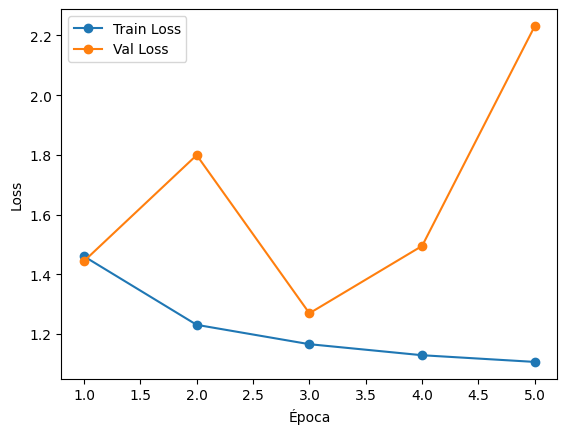

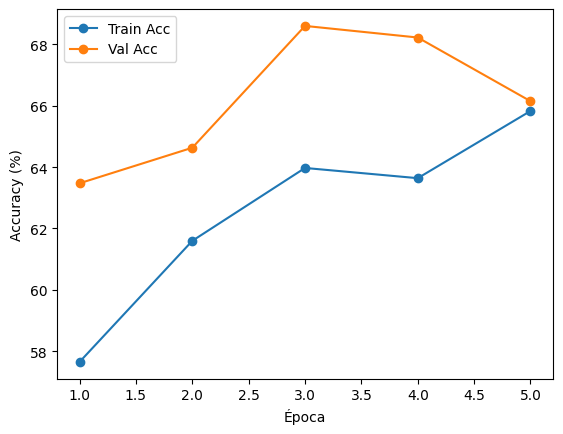

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TwoLayerNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


history = {
    "train_loss": [],
    "val_loss": [],
    "train_acc": [],
    "val_acc": []
}

def evaluate(loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x,y in loader:
            x,y = x.to(device), y.to(device)
            preds = model(x).argmax(dim=1)
            correct += (preds==y).sum().item()
            total   += y.size(0)
    return 100*correct/total

def evaluate_loss(loader):
    model.eval()
    total_loss = 0
    total = 0
    with torch.no_grad():
        for x,y in loader:
            x,y = x.to(device), y.to(device)
            out  = model(x)
            loss = criterion(out, y)
            total_loss += loss.item() * y.size(0)
            total      += y.size(0)
    return total_loss / total

epochs = 5
for epoch in range(1, epochs+1):
    model.train()
    total_loss = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out  = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * y.size(0)

    train_loss = total_loss / len(train_loader.dataset)
    val_loss   = evaluate_loss(test_loader)
    train_acc  = evaluate(train_loader)
    val_acc    = evaluate(test_loader)

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)

    print(f"Epoch {epoch}/{epochs} | "
          f"Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

epochs_list = list(range(1, epochs+1))

plt.figure()
plt.plot(epochs_list, history["train_loss"], marker='o', label="Train Loss")
plt.plot(epochs_list, history["val_loss"],   marker='o', label="Val Loss")
plt.xlabel("Época"); plt.ylabel("Loss"); plt.legend(); plt.show()

plt.figure()
plt.plot(epochs_list, history["train_acc"], marker='o', label="Train Acc")
plt.plot(epochs_list, history["val_acc"],   marker='o', label="Val Acc")
plt.xlabel("Época"); plt.ylabel("Accuracy (%)"); plt.legend(); plt.show()

In [10]:
def predict_random_image(model, dataset, class_names=None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    idx = random.randint(0, len(dataset) - 1)
    image, label = dataset[idx]
    image_input = image.unsqueeze(0).to(device)

    with torch.no_grad():
        out = model(image_input)
        pred = torch.argmax(out, 1).item()

    # des-normaliza y pasa a numpy para plt
    img_np = image.permute(1,2,0).cpu().numpy()
    img_np = (img_np * 0.5 + 0.5).clip(0,1)

    plt.imshow(img_np)
    plt.title(f"Real: {label} | Predicho: {pred}")
    plt.axis('off')
    plt.show()

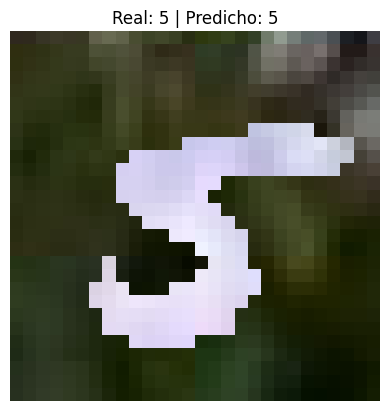

In [11]:
predict_random_image(model, test_ds)

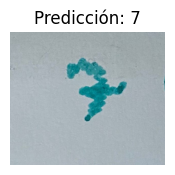

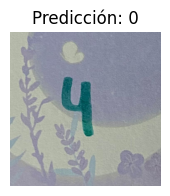

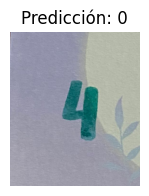

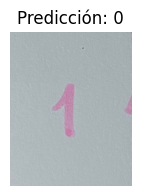

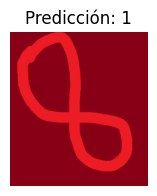

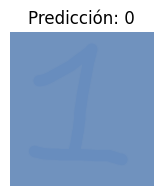

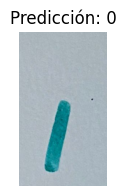

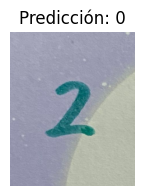

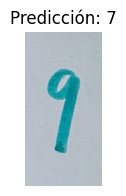

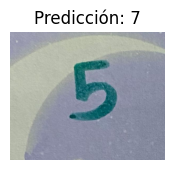

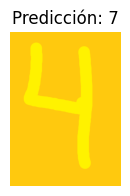

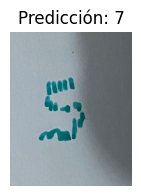

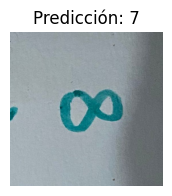

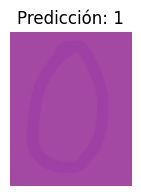

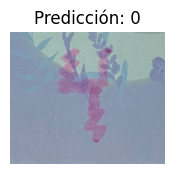

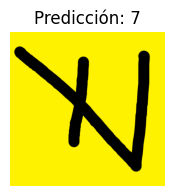

In [15]:
import os, glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch

drive_test_folder = '/content/ImgPrueba'
img_paths = glob.glob(os.path.join(drive_test_folder, '*.*'))
img_paths = [p for p in img_paths if p.lower().endswith(('.png','.jpg','.jpeg'))]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device).eval()

for path in img_paths:
    img = Image.open(path).convert('RGB')
    inp = transform_test(img).unsqueeze(0).to(device)

    with torch.no_grad():
        out  = model(inp)
        pred = int(out.argmax(1))

    plt.figure(figsize=(2,2))
    plt.imshow(np.array(img))
    plt.title(f"Predicción: {pred}")
    plt.axis('off')
    plt.show()